In [1]:
import pandas as pd
import joblib
from data_processing.main import read_scoreset
from tqdm import tqdm
from pathlib import Path
from data_processing.mapping_nbs import mapping_utils
from data_processing.mapping_nbs import plotting
pd.set_option('display.max_columns', 500)

dataset_name = "Findlay_VHL_SGE"
dataset_path = Path("/data/dzeiberg/mave_calibration/data/") / dataset_name
assert dataset_path.exists()

In [3]:
metadata, gene_info, gnomAD_df, spliceAI_df, clinvar_df = mapping_utils.load_mapping_data()

In [13]:
scoreset = read_scoreset(dataset_path / "scoreset.csv").assign(CHROM='3')
scoreset = scoreset.assign(POS=scoreset.POSITION.astype(str)).set_index(['CHROM','POS','REF','ALT'])

In [14]:
scoreset.head()

POSITION     cHGVS   pHGVS     score   q_value  \
CHROM POS      REF ALT                                                   
3     10141958 G   C    10141958  c.111G>C  p.E37D  0.227104  0.999801   
                   T    10141958  c.111G>T  p.E37D  0.480106  0.999801   
      10141959 T   A    10141959  c.112T>A  p.S38T -0.065021  0.736202   
                   G    10141959  c.112T>G  p.S38A  0.235124  0.999801   
      10141960 C   A    10141960  c.113C>A  p.S38Y -0.324690  0.124480   

                        rna_score  rna_score_day_20  delta_rna function_class  \
CHROM POS      REF ALT                                                          
3     10141958 G   C     0.146014          0.049020  -0.096993        Neutral   
                   T     0.496812          0.314450  -0.182362        Neutral   
      10141959 T   A    -0.072035         -0.281796  -0.209761        Neutral   
                   G    -2.064347         -1.778039   0.286308        Neutral   
      10141960 C   A     0.548857          0.549808   0.000951   Intermediate   

                       sge_region  Intron Exon  cDNApos  CDSpos  Chrom  \
CHROM POS      REF ALT                                                   
3     10141958 G   C      exon 1b     NaN  1/3    951.0   111.0      3   
                   T      exon 1b     NaN  1/3    951.0   111.0      3   
      10141959 T   A      exon 1b     NaN  1/3    952.0   112.0      3   
                   G      exon 1b     NaN  1/3    952.0   112.0      3   
      10141960 C   A      exon 1b     NaN  1/3    953.0   113.0      3   

                                conseq oAA nAA        CCDS  protPos  \
CHROM POS      REF ALT                                                
3     10141958 G   C    NON_SYNONYMOUS   E   D  CCDS2597.1     37.0   
                   T    NON_SYNONYMOUS   E   D  CCDS2597.1     37.0   
      10141959 T   A    NON_SYNONYMOUS   S   T  CCDS2597.1     38.0   
                   G    NON_SYNONYMOUS   S   A  CCDS2597.1     38.0   
      10141960 C   A    NON_SYNONYMOUS   S   Y  CCDS2597.1     38.0   

                                                                  variant  \
CHROM POS      REF ALT                                                      
3     10141958 G   C    GAGTACGGCCCTGAAGAAGACGGCGGGGAGGAGTCGGGCGCCGAGG...   
                   T    GAGTACGGCCCTGAAGAAGACGGCGGGGAGGAGTCGGGCGCCGAGG...   
      10141959 T   A    GAGTACGGCCCTGAAGAAGACGGCGGGGAGGAGTCGGGCGCCGAGG...   
                   G    GAGTACGGCCCTGAAGAAGACGGCGGGGAGGAGTCGGGCGCCGAGG...   
      10141960 C   A    GAGTACGGCCCTGAAGAAGACGGCGGGGAGGAGTCGGGCGCCGAGG...   

                       cigar           edit_string  tHDR_pre  tHDR_post  \
CHROM POS      REF ALT                                                    
3     10141958 G   C    214M  48-X-C,72-X-C,87-X-A       503        735   
                   T    214M  48-X-T,72-X-C,87-X-A       581        923   
      10141959 T   A    214M  49-X-A,72-X-C,87-X-A       394        442   
                   G    214M  49-X-G,72-X-C,87-X-A       483        498   
      10141960 C   A    214M  50-X-A,72-X-C,87-X-A       366        411   

                        tHDR_lib  tHDR_neg  tHDR_rna  tHDR_post2  tHDR_rna2  \
CHROM POS      REF ALT                                                        
3     10141958 G   C        1355         1     208.0         655      246.0   
                   T        1925         1     244.0         549      353.0   
      10141959 T   A         891         2     193.0         369      162.0   
                   G        1301         1      84.0         415       67.0   
      10141960 C   A         959         1     156.0         335      213.0   

                        rLD2_tHDR_pre  rLD2_tHDR_lib  rLD2_tHDR_post  \
CHROM POS      REF ALT                                                 
3     10141958 G   C              426           1355             626   
                   T              483           1925             915   
      101419

In [15]:
if 'author_transcript' not in scoreset.columns or scoreset.author_transcript.isna().all():
    AUTHOR_TRANSCRIPT = gene_info.loc[metadata.loc[dataset_name],'MANE_RefSeq_nuc'].values[0].split(".")[0]
else:
    AUTHOR_TRANSCRIPT = scoreset.author_transcript.iloc[0].split(".")[0]

In [16]:
AUTHOR_TRANSCRIPT

'ENTS000000256474'

In [20]:
clinvar_nuc_summaries = clinvar_df[clinvar_df.index.isin(scoreset.index)].groupby(level=list(range(4)),).apply(mapping_utils.summarize_clinvar_group)
clinvar_nuc_summaries.index.rename(['CHROM',"POS",'REF','ALT'],inplace=True)

In [21]:
clinvar_nuc_summaries

num_p_lp  num_b_lb  num_conflicting  num_VUS  \
CHROM POS      REF ALT                                                 
3     10141851 C   T           0         0                0        1   
      10141861 C   T           0         0                0        1   
      10141865 G   C           0         0                0        1   
      10141877 G   C           0         0                0        1   
      10141878 G   C           0         0                1        0   
...                          ...       ...              ...      ...   
      10149963 T   A           0         0                1        0   
                   C           1         0                0        0   
      10149964 G   T           1         0                0        0   
      10149965 A   G           1         0                0        0   
                   T           1         0                0        0   

                                                  clinvar_names  \
CHROM POS      REF ALT                                            
3     10141851 C   T        NM_000551.4(VHL):c.4C>T (p.Pro2Ser)   
      10141861 C   T       NM_000551.4(VHL):c.14C>T (p.Ala5Val)   
      10141865 G   C       NM_000551.4(VHL):c.18G>C (p.Glu6Asp)   
      10141877 G   C      NM_000551.4(VHL):c.30G>C (p.Glu10Asp)   
      10141878 G   C      NM_000551.4(VHL):c.31G>C (p.Ala11Pro)   
...                                                         ...   
      10149963 T   A    NM_000551.4(VHL):c.640T>A (p.Ter214Arg)   
                   C    NM_000551.4(VHL):c.640T>C (p.Ter214Arg)   
      10149964 G   T    NM_000551.4(VHL):c.641G>T (p.Ter214Leu)   
      10149965 A   G    NM_000551.4(VHL):c.642A>G (p.Ter214Trp)   
                   T    NM_000551.4(VHL):c.642A>T (p.Ter214Cys)   

                        clinvar_records  clinvar_spliceAI_max  
CHROM POS      REF ALT                                         
3     10141851 C   T                  1                  0.00  
      10141861 C   T                  1                  0.01  
      10141865 G   C                  1                  0.00  
      10141877 G   C                  1                  0.02  
      10141878 G   C                  1                  0.00  
...                                 ...                   ...  
      10149963 T   A                  1                  0.00  
                   C                  1                  0.00  
      10149964 G   T                  1                  0.00  
      10149965 A   G                  1                  0.00  
                   T                  1                  0.00  

[776 rows x 7 columns]

In [22]:
scoreset_w_clinvar = pd.merge(scoreset,clinvar_nuc_summaries,
                            left_index=True,
                            right_index=True,
                            how="left",
                            validate="one_to_one",
                            suffixes=("","_clinvar"))

In [23]:
scoreset_w_clinvar

POSITION     cHGVS   pHGVS     score   q_value  \
CHROM POS      REF ALT                                                   
3     10141958 G   C    10141958  c.111G>C  p.E37D  0.227104  0.999801   
                   T    10141958  c.111G>T  p.E37D  0.480106  0.999801   
      10141959 T   A    10141959  c.112T>A  p.S38T -0.065021  0.736202   
                   G    10141959  c.112T>G  p.S38A  0.235124  0.999801   
      10141960 C   A    10141960  c.113C>A  p.S38Y -0.324690  0.124480   
...                          ...       ...     ...       ...       ...   
      10141956 G   T    10141956  c.109G>T  p.E37*  1.197395  0.986207   
      10141947 G   C    10141947  c.100G>C  p.G34R  1.199658  0.986207   
      10141951 C   A    10141951  c.104C>A  p.A35D  1.452510  0.986207   
      10141936 G   T    10141936   c.89G>T  p.G30V  1.506749  0.986207   
      10141951 C   T    10141951  c.104C>T  p.A35V  1.525030  0.986207   

                        rna_score  rna_score_day_20  delta_rna function_class  \
CHROM POS      REF ALT                                                          
3     10141958 G   C     0.146014          0.049020  -0.096993        Neutral   
                   T     0.496812          0.314450  -0.182362        Neutral   
      10141959 T   A    -0.072035         -0.281796  -0.209761        Neutral   
                   G    -2.064347         -1.778039   0.286308        Neutral   
      10141960 C   A     0.548857          0.549808   0.000951   Intermediate   
...                           ...               ...        ...            ...   
      10141956 G   T          NaN               NaN        NaN            NaN   
      10141947 G   C          NaN               NaN        NaN            NaN   
      10141951 C   A          NaN               NaN        NaN            NaN   
      10141936 G   T          NaN               NaN        NaN            NaN   
      10141951 C   T          NaN               NaN        NaN            NaN   

                       sge_region  Intron Exon  cDNApos  CDSpos  Chrom  \
CHROM POS      REF ALT                                                   
3     10141958 G   C      exon 1b     NaN  1/3    951.0   111.0      3   
                   T      exon 1b     NaN  1/3    951.0   111.0      3   
      10141959 T   A      exon 1b     NaN  1/3    952.0   112.0      3   
                   G      exon 1b     NaN  1/3    952.0   112.0      3   
      10141960 C   A      exon 1b     NaN  1/3    953.0   113.0      3   
...                           ...     ...  ...      ...     ...    ...   
      10141956 G   T      exon 1c     NaN  1/3    949.0   109.0      3   
      10141947 G   C      exon 1c     NaN  1/3    940.0   100.0      3   
      10141951 C   A      exon 1c     NaN  1/3    944.0   104.0      3   
      10141936 G   T      exon 1c     NaN  1/3    929.0    89.0      3   
      10141951 C   T      exon 1c     NaN  1/3    944.0   104.0      3   

                                conseq oAA nAA        CCDS  protPos  \
CHROM POS      REF ALT                                                
3     10141958 G   C    NON_SYNONYMOUS   E   D  CCDS2597.1     37.0   
                   T    NON_SYNONYMOUS   E   D  CCDS2597.1     37.0   
      10141959 T   A    NON_SYNONYMOUS   S   T  CCDS2597.1     38.0   
                   G    NON_SYNONYMOUS   S   A  CCDS2597.1     38.0   
      10141960 C   A    NON_SYNONYMOUS   S   Y  CCDS2597.1     38.0   
...                                ...  ..  ..         ...      ...   
      10141956 G   T       STOP_GAINED   E   *  CCDS2597.1     37.0   
      10141947 G   C    NON_SYNONYMOUS   G   R  CCDS2597.1     34.0   
      10141951 C   A    NON_SYNONYMOUS   A   D  CCDS2597.1     35.0   
      10141936 G   T    NON_SYNONYMOUS   G   V  CCDS2597.1     30.0   
      10141951 C   T    NON_SYNONYMOUS   A   V  CCDS2597.1     35.0   

                                                                  variant  \
CHROM POS      REF ALT                     

In [24]:
AUTHOR_TRANSCRIPT

'ENTS000000256474'

In [28]:
gnomAD_matches = gnomAD_df[(gnomAD_df.index.isin(scoreset.index)) & (gnomAD_df.SYMBOL == "VHL")].sort_values(by='AC',ascending=False)

gnomAD_matches_unique = gnomAD_matches[~gnomAD_matches.index.duplicated(keep='first')]

In [29]:
gnomAD_matches_unique

ID  QUAL FILTER   AC            AF  \
CHROM POS      REF ALT                                                 
3     10142088 C   T     rs104893829 -10.0   PASS  513  3.530580e-04   
      10149921 C   T      rs28940298 -10.0   PASS  351  2.401080e-04   
      10149952 G   A     rs138780791 -10.0   PASS  169  1.156330e-04   
      10142019 C   T     rs757781272 -10.0   PASS   94  6.531700e-05   
      10149897 C   T      rs28940300 -10.0   PASS   84  5.746000e-05   
...                              ...   ...    ...  ...           ...   
      10142041 C   G       rs5030826 -10.0   PASS    1  6.894180e-07   
      10142044 T   G    rs2125124970 -10.0   PASS    1  6.889830e-07   
      10142139 T   C       rs5030809 -10.0   PASS    1  6.906880e-07   
      10142143 C   G    rs1553619452 -10.0   PASS    1  6.908020e-07   
      10142146 C   G    rs1346874866 -10.0   PASS    1  6.569870e-06   

                                                                      vep  \
CHROM POS      REF ALT                                                      
3     10142088 C   T    T|missense_variant|MODERATE|VHL|ENSG0000013408...   
      10149921 C   T    T|missense_variant|MODERATE|VHL|ENSG0000013408...   
      10149952 G   A    A|missense_variant|MODERATE|VHL|ENSG0000013408...   
      10142019 C   T    T|missense_variant|MODERATE|VHL|ENSG0000013408...   
      10149897 C   T    T|missense_variant|MODERATE|VHL|ENSG0000013408...   
...                                                                   ...   
      10142041 C   G    G|missense_variant|MODERATE|VHL|ENSG0000013408...   
      10142044 T   G    G|missense_variant|MODERATE|VHL|ENSG0000013408...   
      10142139 T   C    C|missense_variant|MODERATE|VHL|ENSG0000013408...   
      10142143 C   G    G|missense_variant|MODERATE|VHL|ENSG0000013408...   
      10142146 C   G    G|missense_variant|MODERATE|VHL|ENSG0000013408...   

                        index Allele       Consequence    IMPACT SYMBOL  \
CHROM POS      REF ALT                                                    
3     10142088 C   T      469      T  missense_variant  MODERATE    VHL   
      10149921 C   T     2996      T  missense_variant  MODERATE    VHL   
      10149952 G   A     3030      A  missense_variant  MODERATE    VHL   
      10142019 C   T      394      T  missense_variant  MODERATE    VHL   
      10149897 C   T     2975      T  missense_variant  MODERATE    VHL   
...                       ...    ...               ...       ...    ...   
      10142041 C   G      422      G  missense_variant  MODERATE    VHL   
      10142044 T   G      424      G  missense_variant  MODERATE    VHL   
      10142139 T   C      527      C  missense_variant  MODERATE    VHL   
      10142143 C   G      530      G  missense_variant  MODERATE    VHL   
      10142146 C   G      538      G  missense_variant  MODERATE    VHL   

                                   Gene Feature_type          Feature  \
CHROM POS      REF ALT                                                  
3     10142088 C   T    ENSG00000134086   Transcript  ENST00000256474   
      10149921 C   T               7428   Transcript      NM_198156.3   
      10149952 G   A               7428   Transcript      NM_000551.4   
      10142019 C   T               7428   Transcript      NM_198156.3   
      10149897 C   T               7428   Transcript      NM_000551.4   
...                                 ...          ...              ...   
      10142041 C   G    ENSG00000134086   Transcript  ENST00000256474   
      10142044 T   G    ENSG00000134086   Transcript  ENST00000256474   
      10142139 T   C    ENSG00000134086   Transcript  ENST00000256474   
      10142143 C   G    ENSG00000134086   Transcript  ENST00000256474   
      10142146 C   G    ENSG00000134086   Transcript  ENST00000256474   

                               BIOTYPE EXON  INTRON  \
CHROM POS      REF ALT                                
3     10142088 C   T    protein_coding  1/3     NaN   
    

In [32]:
scoreset_processed = pd.merge(scoreset_w_clinvar,gnomAD_matches_unique,
                                        left_index=True,right_index=True,how="left",validate="one_to_one")#.reset_index()

In [33]:
scoreset_processed.to_csv(dataset_path / "scoreset_processed.csv",index=False)

In [2]:
scoreset_processed = pd.read_csv(dataset_path / "scoreset_processed.csv")

<Axes: >

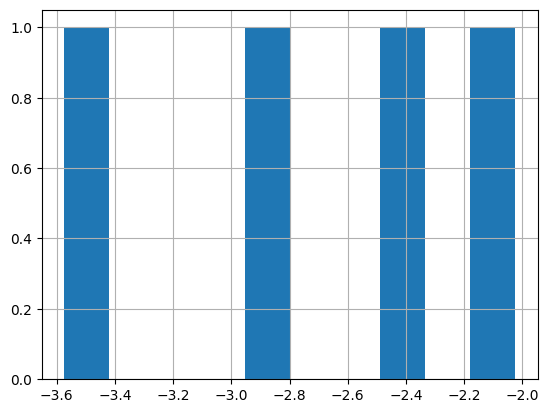

In [9]:
scoreset_processed.loc[(scoreset_processed.num_p_lp > 0) & (scoreset_processed.clinvar_spliceAI_max > .5)].score.hist()

In [34]:
def conflicting_interpretations(r):
    """
    Check if a record has conflicting interpretations
    P/LP and B/LB ; P/LP and VUS ; B/LB and VUS ; P/LP and conflicting ; B/LB and conflicting
    If data is mapped at the protein level, this could be a result of different RNA substitutions
    If data is mapped at the RNA level, this is a true conflict

    Parameters
    ----------
    r : pd.Series
        A record from the ClinVar data frame

    Returns
    -------
    bool
        True if there are conflicting interpretations, False otherwise
    """
    return r.num_p_lp > 0 and r.num_b_lb > 0 or \
            r.num_p_lp > 0 and r.num_VUS > 0 or \
            r.num_b_lb > 0 and r.num_VUS > 0 or \
            r.num_p_lp > 0 and r.num_conflicting > 0 or \
            r.num_b_lb > 0 and r.num_conflicting > 0


def is_pathogenic(r):
    return r.num_p_lp > 0 and not conflicting_interpretations(r) and r.clinvar_spliceAI_max <= .5

def is_benign(r):
    return r.num_b_lb > 0 and not conflicting_interpretations(r) and r.clinvar_spliceAI_max <= .5

def is_vus(r):
    return r.num_VUS > 0

def is_conflicting(r):
    return r.num_conflicting > 0

def is_gnomAD(r):
    return r.AF > 0 and r.spliceAI_scores <= .5

def is_synonymous(r):
    return r.synonymous and r.num_p_lp == 0 and r.clinvar_spliceAI_max <= .5



In [35]:
INVERT_SCORES = False

sample_data = {
    "P/LP" : scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_pathogenic(r),axis=1)],
    "B/LB" : scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_benign(r),axis=1)],
    'gnomAD': scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_gnomAD(r),axis=1)],
    'synonymous' : scoreset_processed[scoreset_processed.apply(is_synonymous,axis=1)],
}
sample_data = {k : v for k,v in sample_data.items() if len(v)}

if INVERT_SCORES:
    for k in sample_data:
        sample_data[k] = sample_data[k].assign(score= -sample_data[k].score)


In [36]:
for sample_name, sample in sample_data.items():
    print(f"{sample_name}: {sample.shape[0]}")

P/LP: 143
B/LB: 183
gnomAD: 259
synonymous: 195


(<Figure size 1200x1200 with 4 Axes>,
 array([<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>], dtype=object))

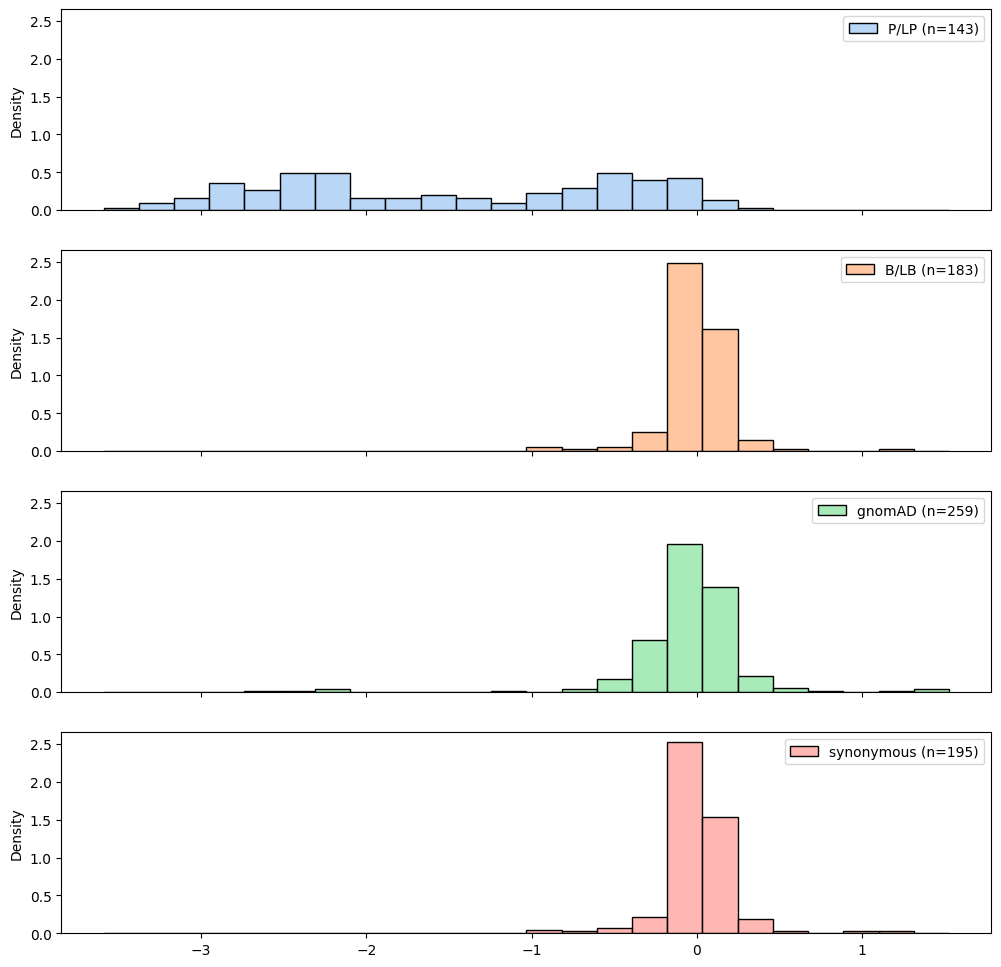

In [37]:
plotting.plot_samples({k : v.score.values for k,v in sample_data.items()})

In [38]:
pd.DataFrame.from_records([*[dict(sample_name='P/LP',score=score) for score in sample_data['P/LP'].score.values],
                            *[dict(sample_name='B/LB',score=score) for score in sample_data['B/LB'].score.values],
                            *[dict(sample_name='gnomAD',score=score) for score in sample_data['gnomAD'].score.values],
                            *[dict(sample_name='synonymous',score=score) for score in sample_data['synonymous'].score.values]]).to_csv(dataset_path / "samples.csv",index=False)